### This notebook is meant to be run in Colab. It clones data and code from the GitHub repo.

In [1]:
# Installs packages and clones GitHub repo to Colab
!pip install import-ipynb # to import functions from other ipynb files
!git clone https://github.com/peepkolberg/CNS-EOG-classifier.git
%cd CNS-EOG-classifier/

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=cf6fd8662c87968c961b4e499aeba02b5fb59829688909309ba01460315aab7b
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
Cloning into 'CNS-EOG-classifier'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 101 (delta 29), reused 45 (delta 17), pack-reused 43
Receiving objects: 100% (101/101), 21.92 MiB | 28.31 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/CNS-EOG-classifier


In [2]:
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import preprocess    #import the preprocess notebook

importing Jupyter notebook from preprocess.ipynb
     |████████████████████████████████| 1.1 MB 7.1 MB/s 




On average, 187k rows of data per experiment, 23k per class.


Average standard deviation of the gap between each measurement in each class of each experiment





In [14]:
# Various data preparing functions. 

def safely_remove_distraction_classes(datasets_dict):
    """
    Removes the distraction classes (labels 7 and 8) from the datasets without concatenating the surrounding class.
    Since each distraction is in the middle of another class, this function separates the surrounding class into two parts.
    The parts will be denoted by appending .1 or .2 to the surrounding class labels that are before and after the distraction class, respectively.
    """
    for participant, experiments in datasets_dict.items():
        for experiment, df in experiments.items():
            for dis_label in (7, 8):
                dis_df_idx = df[df['class'] == dis_label].index
    
                dis_start_idx = dis_df_idx[0]
                dis_end_idx = dis_df_idx[-1]
        
                surrounding_class_label = df['class'][dis_start_idx - 1]
            
                before_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index < dis_start_idx) ]
                after_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index > dis_end_idx) ]
                
                df.loc[before_dis_class.index[0] : dis_start_idx, 'class'] = surrounding_class_label + 0.1
                df.loc[after_dis_class.index[0] : after_dis_class.index[-1]+1, 'class'] = surrounding_class_label + 0.2
                
                df.drop(index=range(dis_start_idx, dis_end_idx+1), inplace=True)
                #print(df['class'].unique())

def data_split(df, data_columns, chunk_size, window_step):
  """
  Outputs: NumPy arrays of data (X) and labels (y)

  Splits time-series data into equal-sized chunks.
  Also removes the .1 and .2 from previously separated labels.
  """

  X = []
  y = []

  for label in df['class'].unique():
    class_df = df[df['class'] == label]

    signals = np.asarray(class_df[data_columns])
    
    for i in range(0, len(signals), window_step): 
      chunk = signals[i : i + chunk_size]

      if len(chunk) != chunk_size:
        break

      X.append(chunk)
      y.append(int(label))

  return np.asarray(X), np.asarray(y) - 1    # Subtracting 1 from labels because keras tools expect numerical labels to start from 0

def split_datasets(datasets_dict, data_columns, chunk_size, sliding_window_step = -1):
  """ 
  Input: datasets_dict - 2D dictionary; hierarchy: dict[participant][experiment]
  Splits each dataset into chunks. If sliding_window_step argument is given, applies sliding window sampling.
  Also separates signal data (X) and labels (y).
  """

  # If step is not passed, move the window by the entire length of the window.
  if sliding_window_step == -1:
    sliding_window_step = chunk_size

  for participant, exps in datasets_dict.items():
    for experiment, data in exps.items():
      X, y = data_split(data, data_columns, chunk_size, sliding_window_step)
      datasets_dict[participant][experiment] = {'X': X, 'y': y} # <-- To also rename labels to their corresponding words, use rename_labels(y) instead of y

def one_hot_encode_labels(datasets_dict):
  for exps in datasets_dict.values():
    for data in exps.values():
      data['y'] = to_categorical(data['y'])

def print_data_dimensions(datasets_dict, cols):
  print('Rows in each experiment...')
  total_rows = 0
  total_labels = 0
  for participant, experiments in datasets_dict.items():
    for experiment, data in experiments.items():
      print(f"participant:{participant}   experiment:{experiment}")
      sig_shape = np.shape(data[cols])
      lab_shape = np.shape(data['class'])
      print(f"signals shape:{sig_shape}")
      print(f" labels shape:{lab_shape}")
      total_rows += sig_shape[0]
      total_labels += lab_shape[0]
  print(f"\nTotal {total_rows} rows of data and {total_labels} labels.")
  assert total_rows == total_labels

def concat_datasets(datasets_dict, participants, data_columns):
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e][data_columns])
      y.append(datasets_dict[p][e]['class'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

def labels_to_words(numerical_labels):
    """ 
    For converting labels from numbers (0-7) to their word representations ('null', 'read', etc.)
    Input: numerical labels as a 1D array. 
    """
    replacements = {0: 'null', 
                    1: 'read', 
                    2: 'browse', 
                    3: 'write', 
                    4: 'video', 
                    5: 'copy', 
                    6: 'disspeak', 
                    7: 'disphone'}
    return np.asarray([replacements[old_label] for old_label in numerical_labels])

def plot_conf_matrix(true_labels, predictions):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, predictions)).plot(cmap=plt.cm.Blues)
  plt.title(f"Participant {testing_participant} confusion matrix")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  plt.show()

def normalize_per_dataset(datasets_dict, data_columns):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      for col_name in data_columns:
        initial = np.asarray(data[col_name])
        max, min = np.max(initial), np.min(initial)
        normalized = 2 * ( (initial-min) / (max-min) ) - 1 # normalize between -1 and 1
        data[col_name] = normalized

def standardize(standardized_dict, datasets_dict, participants, data_columns, scaler):
  for p in participants:
    standardized_dict[p] = {}
    
    for e, experiment_data in datasets_dict[p].items():
      standardized_dict[p][e] = pd.DataFrame(data = scaler.transform(experiment_data[data_columns]), columns = data_columns)
      standardized_dict[p][e]['class'] = copy.deepcopy(datasets_dict[p][e]['class'])

  return standardized_dict

def concat_chunks(datasets_dict, participants):
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e]['X'])
      y.append(datasets_dict[p][e]['y'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

In [4]:
# Read files into dataframes (see function description in preprocess.ipynb for details)
datasets_dict = preprocess.read_all_files()

# Remove distraction classes
# The classes that surround the distraction class will be split into two parts by appending .1 or .2 to the label. 
safely_remove_distraction_classes(datasets_dict)

# Define which columns contain the desired signal data
data_columns = [
                #'signal_horizontal', 
                #'signal_vertical', 
                'signal_horizontal_nk', 
                'signal_vertical_nk'
                ]

# Normalization/standardization,
# splitting into chunks, and 
# one-hot-encoding labels is done in the training loop.

# Print the final dimensions of each dataset
print_data_dimensions(datasets_dict, data_columns)

Rows in each experiment...
participant:1   experiment:0
signals shape:(95555, 2)
 labels shape:(95555,)
participant:1   experiment:1
signals shape:(153837, 2)
 labels shape:(153837,)
participant:2   experiment:0
signals shape:(216969, 2)
 labels shape:(216969,)
participant:2   experiment:1
signals shape:(113083, 2)
 labels shape:(113083,)
participant:3   experiment:0
signals shape:(213370, 2)
 labels shape:(213370,)
participant:3   experiment:1
signals shape:(219878, 2)
 labels shape:(219878,)
participant:4   experiment:0
signals shape:(194701, 2)
 labels shape:(194701,)
participant:4   experiment:1
signals shape:(191298, 2)
 labels shape:(191298,)
participant:5   experiment:0
signals shape:(204106, 2)
 labels shape:(204106,)
participant:5   experiment:1
signals shape:(174829, 2)
 labels shape:(174829,)
participant:6   experiment:0
signals shape:(207580, 2)
 labels shape:(207580,)
participant:6   experiment:1
signals shape:(184430, 2)
 labels shape:(184430,)
participant:7   experiment:

Training data shape:   (3078, 1280, 2)   labels shape: (3078, 6)
Validation data shape: (770, 1280, 2)     labels shape: (770, 6)
Testing data shape:    (357, 1280, 2)    labels shape: (357, 6)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 1278, 8)           56        
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 639, 8)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 635, 16)           656       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 317, 16)          0         
 g1D)                                                            
                                                         

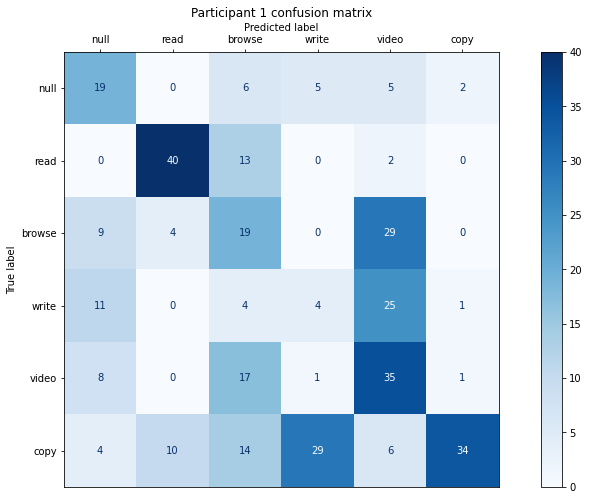

Training data shape:   (2978, 1280, 2)   labels shape: (2978, 6)
Validation data shape: (745, 1280, 2)     labels shape: (745, 6)
Testing data shape:    (482, 1280, 2)    labels shape: (482, 6)


Started training for participant 2

Epoch 1/20
47/47 [==============================] - 14s 277ms/step - loss: 8.5974 - accuracy: 0.2414 - val_loss: 2.3193 - val_accuracy: 0.3262
Epoch 2/20
47/47 [==============================] - 13s 277ms/step - loss: 2.0482 - accuracy: 0.3831 - val_loss: 2.0099 - val_accuracy: 0.4000
Epoch 3/20
47/47 [==============================] - 13s 277ms/step - loss: 1.8711 - accuracy: 0.4577 - val_loss: 1.8452 - val_accuracy: 0.4483
Epoch 4/20
47/47 [==============================] - 13s 279ms/step - loss: 1.8098 - accuracy: 0.4896 - val_loss: 1.8171 - val_accuracy: 0.4859
Epoch 5/20
47/47 [==============================] - 13s 276ms/step - loss: 1.7325 - accuracy: 0.5074 - val_loss: 1.7542 - val_accuracy: 0.4980
Epoch 6/20
47/47 [==============================] - 1

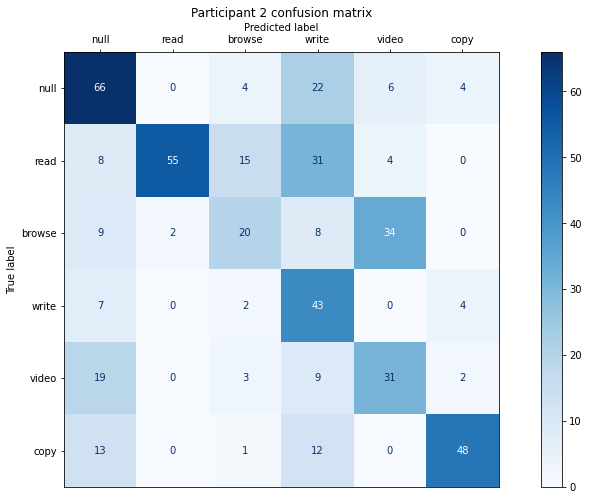

Training data shape:   (2858, 1280, 2)   labels shape: (2858, 6)
Validation data shape: (715, 1280, 2)     labels shape: (715, 6)
Testing data shape:    (632, 1280, 2)    labels shape: (632, 6)


Started training for participant 3

Epoch 1/20
45/45 [==============================] - 13s 276ms/step - loss: 10.2813 - accuracy: 0.2071 - val_loss: 2.7423 - val_accuracy: 0.2811
Epoch 2/20
45/45 [==============================] - 13s 286ms/step - loss: 2.3095 - accuracy: 0.3135 - val_loss: 2.1256 - val_accuracy: 0.3203
Epoch 3/20
45/45 [==============================] - 12s 272ms/step - loss: 2.0336 - accuracy: 0.3520 - val_loss: 1.9950 - val_accuracy: 0.3692
Epoch 4/20
45/45 [==============================] - 13s 282ms/step - loss: 1.9192 - accuracy: 0.3880 - val_loss: 1.9063 - val_accuracy: 0.4070
Epoch 5/20
45/45 [==============================] - 12s 273ms/step - loss: 1.8687 - accuracy: 0.4020 - val_loss: 1.8528 - val_accuracy: 0.4056
Epoch 6/20
45/45 [==============================] - 

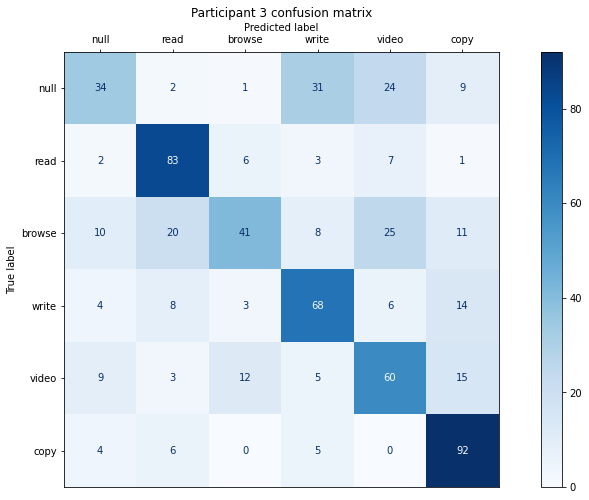

Training data shape:   (2913, 1280, 2)   labels shape: (2913, 6)
Validation data shape: (729, 1280, 2)     labels shape: (729, 6)
Testing data shape:    (563, 1280, 2)    labels shape: (563, 6)


Started training for participant 4

Epoch 1/20
46/46 [==============================] - 13s 269ms/step - loss: 9.2629 - accuracy: 0.2128 - val_loss: 2.4492 - val_accuracy: 0.2689
Epoch 2/20
46/46 [==============================] - 12s 267ms/step - loss: 2.1445 - accuracy: 0.3296 - val_loss: 2.0783 - val_accuracy: 0.2853
Epoch 3/20
46/46 [==============================] - 12s 267ms/step - loss: 1.9220 - accuracy: 0.3907 - val_loss: 1.9720 - val_accuracy: 0.3196
Epoch 4/20
46/46 [==============================] - 12s 271ms/step - loss: 1.8408 - accuracy: 0.4006 - val_loss: 1.8135 - val_accuracy: 0.4047
Epoch 5/20
46/46 [==============================] - 13s 273ms/step - loss: 1.7608 - accuracy: 0.4298 - val_loss: 1.8243 - val_accuracy: 0.3951
Epoch 6/20
46/46 [==============================] - 1

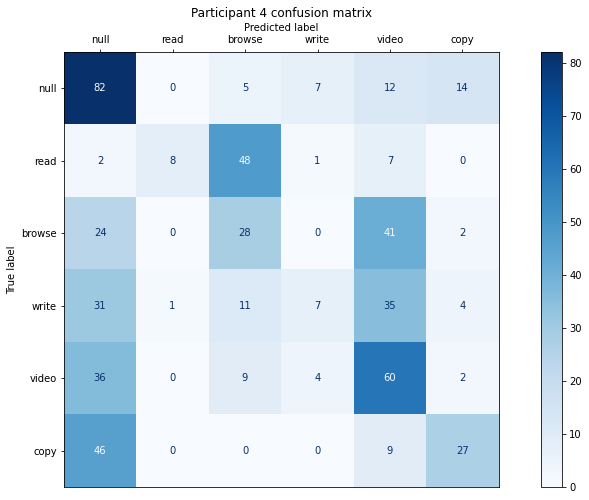

Training data shape:   (2925, 1280, 2)   labels shape: (2925, 6)
Validation data shape: (732, 1280, 2)     labels shape: (732, 6)
Testing data shape:    (548, 1280, 2)    labels shape: (548, 6)


Started training for participant 5

Epoch 1/20
46/46 [==============================] - 14s 277ms/step - loss: 9.4465 - accuracy: 0.2338 - val_loss: 2.4746 - val_accuracy: 0.2773
Epoch 2/20
46/46 [==============================] - 13s 290ms/step - loss: 2.1608 - accuracy: 0.3063 - val_loss: 2.1341 - val_accuracy: 0.2705
Epoch 3/20
46/46 [==============================] - 13s 281ms/step - loss: 1.9828 - accuracy: 0.3501 - val_loss: 1.9315 - val_accuracy: 0.3484
Epoch 4/20
46/46 [==============================] - 13s 279ms/step - loss: 1.8628 - accuracy: 0.3805 - val_loss: 1.8487 - val_accuracy: 0.3566
Epoch 5/20
46/46 [==============================] - 12s 259ms/step - loss: 1.8190 - accuracy: 0.3795 - val_loss: 1.8054 - val_accuracy: 0.4481
Epoch 6/20
46/46 [==============================] - 1

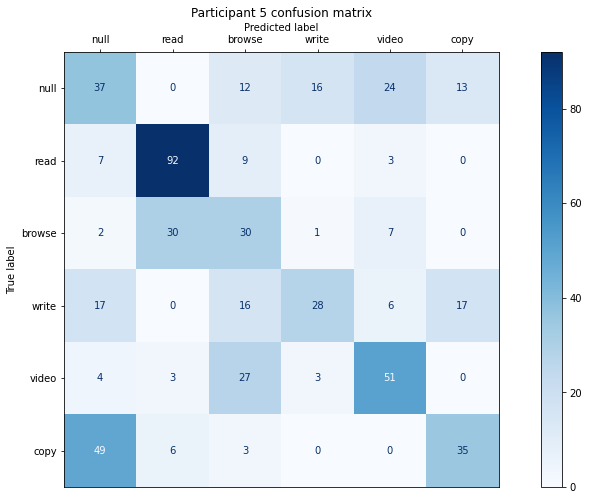

Training data shape:   (2904, 1280, 2)   labels shape: (2904, 6)
Validation data shape: (727, 1280, 2)     labels shape: (727, 6)
Testing data shape:    (574, 1280, 2)    labels shape: (574, 6)


Started training for participant 6

Epoch 1/20
46/46 [==============================] - 14s 277ms/step - loss: 8.6296 - accuracy: 0.2376 - val_loss: 2.2502 - val_accuracy: 0.2847
Epoch 2/20
46/46 [==============================] - 12s 264ms/step - loss: 2.0694 - accuracy: 0.3154 - val_loss: 1.9693 - val_accuracy: 0.3370
Epoch 3/20
46/46 [==============================] - 12s 265ms/step - loss: 1.9046 - accuracy: 0.3402 - val_loss: 1.8212 - val_accuracy: 0.3838
Epoch 4/20
46/46 [==============================] - 13s 274ms/step - loss: 1.8346 - accuracy: 0.3640 - val_loss: 1.7765 - val_accuracy: 0.4017
Epoch 5/20
46/46 [==============================] - 12s 268ms/step - loss: 1.7473 - accuracy: 0.3939 - val_loss: 1.7745 - val_accuracy: 0.3796
Epoch 6/20
46/46 [==============================] - 1

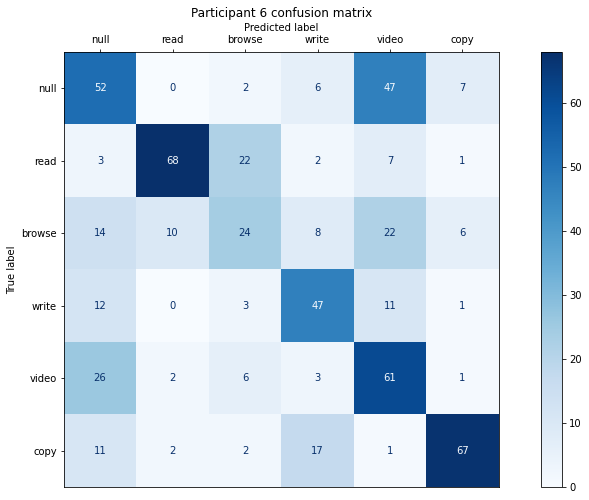

Training data shape:   (2963, 1280, 2)   labels shape: (2963, 6)
Validation data shape: (741, 1280, 2)     labels shape: (741, 6)
Testing data shape:    (501, 1280, 2)    labels shape: (501, 6)


Started training for participant 7

Epoch 1/20
47/47 [==============================] - 14s 287ms/step - loss: 9.3054 - accuracy: 0.2082 - val_loss: 2.4745 - val_accuracy: 0.2429
Epoch 2/20
47/47 [==============================] - 13s 281ms/step - loss: 2.1535 - accuracy: 0.2767 - val_loss: 1.9994 - val_accuracy: 0.2874
Epoch 3/20
47/47 [==============================] - 13s 286ms/step - loss: 1.9398 - accuracy: 0.3318 - val_loss: 1.9457 - val_accuracy: 0.3671
Epoch 4/20
47/47 [==============================] - 13s 276ms/step - loss: 1.8530 - accuracy: 0.3959 - val_loss: 1.7940 - val_accuracy: 0.4777
Epoch 5/20
47/47 [==============================] - 12s 262ms/step - loss: 1.7689 - accuracy: 0.4377 - val_loss: 1.7514 - val_accuracy: 0.4737
Epoch 6/20
47/47 [==============================] - 1

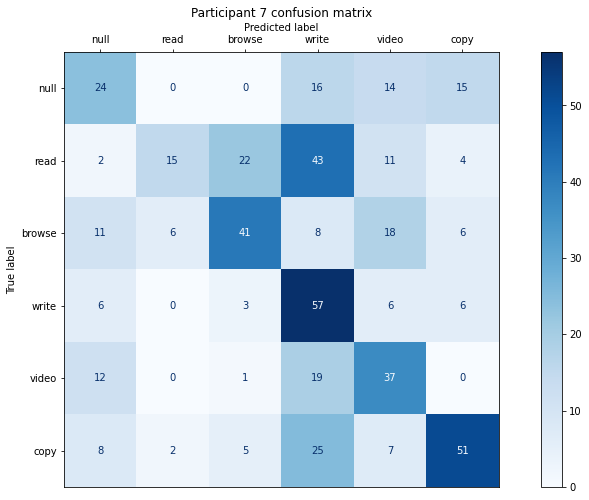

Training data shape:   (2925, 1280, 2)   labels shape: (2925, 6)
Validation data shape: (732, 1280, 2)     labels shape: (732, 6)
Testing data shape:    (548, 1280, 2)    labels shape: (548, 6)


Started training for participant 8

Epoch 1/20
46/46 [==============================] - 14s 284ms/step - loss: 9.2849 - accuracy: 0.2161 - val_loss: 2.4987 - val_accuracy: 0.2828
Epoch 2/20
46/46 [==============================] - 13s 282ms/step - loss: 2.1577 - accuracy: 0.2875 - val_loss: 2.0236 - val_accuracy: 0.3374
Epoch 3/20
46/46 [==============================] - 13s 283ms/step - loss: 1.9267 - accuracy: 0.3501 - val_loss: 1.8985 - val_accuracy: 0.3989
Epoch 4/20
46/46 [==============================] - 12s 271ms/step - loss: 1.8316 - accuracy: 0.4014 - val_loss: 1.8552 - val_accuracy: 0.3893
Epoch 5/20
46/46 [==============================] - 13s 288ms/step - loss: 1.7574 - accuracy: 0.4274 - val_loss: 1.8059 - val_accuracy: 0.3989
Epoch 6/20
46/46 [==============================] - 1

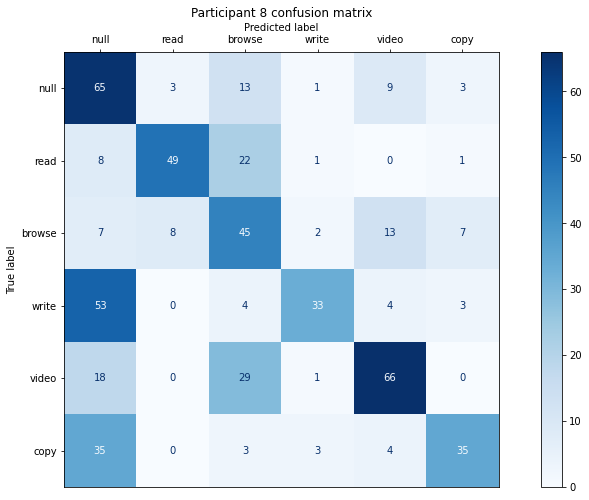

In [16]:
# TESTING REGULAR CNN

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Conv1D, Dense, Dropout, Input, LayerNormalization, BatchNormalization, AveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

import copy

def grid_search(X_train, y_train, X_test, y_test):
  model = KerasClassifier(build_fn=compile_model, verbose=0)

  batch_size = [10, 20, 30, 40, 60, 80, 100]
  epochs = [10, 20, 30, 50, 70, 100]
  optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  cnn_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dense_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

  param_grid = dict(batch_size=batch_size,
                    epochs=epochs, 
                    optimizer=optimizer, 
                    cnn_activation=cnn_activation, 
                    dense_activation=dense_activation, 
                    dropout_rate=dropout_rate
                    )
  
  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])
  test_fold = np.concatenate([np.repeat(-1, len(y_train)), np.repeat(0, len(y_test))])
  
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=PredefinedSplit(test_fold=test_fold))
  grid_result = grid.fit(X, y)

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

def compile_model(input_shape = (625, 4), output_nodes = 6, cnn_activation = 'relu', dense_activation = 'relu', dropout_rate = 0.2):
  model = Sequential()

  # TODO:
  # test way more and larger filters (also in descending order) - no effect (train over 95, val 45)
  # add padding = 'same' to conv layers - close to no effect (train over 95, val 40)
  # Add batchnorms - worse (train over 95, val 30)
  # kernel sizes to 100s (increasing in size), also chunk size to 3640 - slightly better (train over 95, val 50) 
  # weight decay of 0.1 to conv and dense layers - way worse (train 18, val 10)
  # weight decay of 0.05 to conv and dense layers - kinda worse (train 63, val 45)
  # weight decay of 0.001 to conv and dense layers - better (train over 95 and grows fast, val 54)
  # weight decay of 0.01 to conv and dense layers -  best, some weird behaviour appears tho (train over 90 but grows slower, val 55)

  # use Conv1DLSTM layers instead of regular conv
  # try training with only consistently measured data
    # if previous point raises acc, interpolate poorly measured data
  # normalize data to have mean 0 and std 1
  # other weight decays

  model.add(Input(shape = input_shape))

  model.add(Conv1D(8, 3, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(16, 5, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(32, 7, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(64, 9, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Flatten())

  # Automatically find the nr of nodes that the Flatten layer has.
  # The following Dense layer will have the same nr of nodes.
  # Would be great if someone got it to work.
  #print(model.get_layer(index=-1)) # gets the instance of the Flatten() layer

  model.add(Dense(2336, activation=dense_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(Dropout(dropout_rate))
  
  model.add(Dense(output_nodes, activation='softmax'))

  opt = Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def evaluate(model, X_test, y_test):

  true_labels = [np.argmax(el) for el in y_test]
  pred_labels = [np.argmax(el) for el in model.predict(X_test)]

  # 2D dictionary
  # hierarchy: true label -> 'total': how many times that label appears in the test set
  #                       -> predicted label: how many times the model predicted that label
  predictions = {}
  for lab in np.unique(true_labels):
    predictions[lab] = defaultdict(lambda: 0)

  # Count all predictions
  for true_label, pred_label in zip(true_labels, pred_labels):
    predictions[true_label]['total'] += 1
    predictions[true_label][pred_label] += 1

  print('true pred nr')

  # Find the 
  for t_lab, d in predictions.items():
    for lab, count in d.items():
      print(t_lab, lab, count)


# For each test, one participant is the test participant (not included in the training set).
first_iteration = True

for testing_participant in range(1, 9):
  training_participants = list(range(1, 9))
  training_participants.remove(testing_participant)

  # Get concatenated tables for fitting StandardScalers.
  X_train, y_train = concat_datasets(datasets_dict, training_participants, data_columns) # The returned y_train and y_test lists aren't actually used.
  X_test, y_test = concat_datasets(datasets_dict, [testing_participant], data_columns)
  X_train = pd.DataFrame(data = X_train, columns = data_columns)
  X_test = pd.DataFrame(data = X_test, columns = data_columns)

  # Fit the scalers on both whole datasets.
  train_scaler = StandardScaler(copy = True).fit(X_train) # These scalers do NOT change the values in-place, but return a copy.
  test_scaler = StandardScaler(copy = True).fit(X_test)

  # Standardize the training and test sets.
  standardized_dict = standardize({}, datasets_dict, training_participants, data_columns, train_scaler) 
  standardized_dict = standardize(standardized_dict, datasets_dict, [testing_participant], data_columns, test_scaler)

  # Split each class in dataset into chunks. Can be used for sliding window sampling (sliding_window_step argument must be given).
  # Also subtracts 1 from all labels so they start from 0.
  chunk_size = 1280
  sliding_window_step = 640
  split_datasets(standardized_dict, data_columns, chunk_size, sliding_window_step)

  # One-hot encode labels
  one_hot_encode_labels(standardized_dict)

  # Concatenate chunks
  X_train, y_train = concat_chunks(standardized_dict, training_participants)
  X_test, y_test = concat_chunks(standardized_dict, [testing_participant])

  # Further divide the training set into training and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2) # this also shuffles train and val sets

  print(f"\nStarted training for participant {testing_participant}\n")
  print(f"Training data shape:   {X_train.shape}   labels shape: {y_train.shape}")
  print(f"Validation data shape: {X_val.shape}     labels shape: {y_val.shape}")
  print(f"Testing data shape:    {X_test.shape}    labels shape: {y_test.shape}\n")

  # Makes a fresh model for every person
  model = compile_model(input_shape = X_train.shape[1:], output_nodes = y_train.shape[1])

  if first_iteration: # print the model summary only on the first iteration
    model.summary()
    first_iteration = False

  
  #break

  # Run Grid Search or fit the model (uncomment one line or the other)
  #grid_search(X_train, y_train, X_test, y_test)
  model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), verbose=1)

  # Get the model's predictions for each chunk
  print(f"Testing participant {testing_participant}\n")
  true_labels = [np.argmax(el) for el in y_test]
  predictions = [np.argmax(el) for el in model.predict(X_test)]

  # Classify the entire signal
  #classify(predictions, true_labels)

  # Plot the confusion matrix (comment this segment out if running Grid Search)
  plot_conf_matrix(true_labels, predictions)

  #break